In [ ]:
pip install keras-tuner

In [1]:
pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd 
from tensorflow import keras
import keras as k
from matplotlib import pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
import plotly.offline as py
import plotly.graph_objs as go
import keras_tuner as kt
import tensorflow as tf
from IPython.display import SVG
import os
import datetime, time
import random
from keras import backend as K
from keras.regularizers import L1L2
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('gold_price_data.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df = pd.read_csv("gold_price_data.csv")
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10787 non-null  object 
 1   Value   10787 non-null  float64
dtypes: float64(1), object(1)
memory usage: 168.7+ KB


In [ ]:
df.describe()

,Value
count,10787.000000
mean,653.596634
std,434.030848
min,35.100000
25%,349.200000
50%,409.350000
75%,1061.625000
max,1895.000000


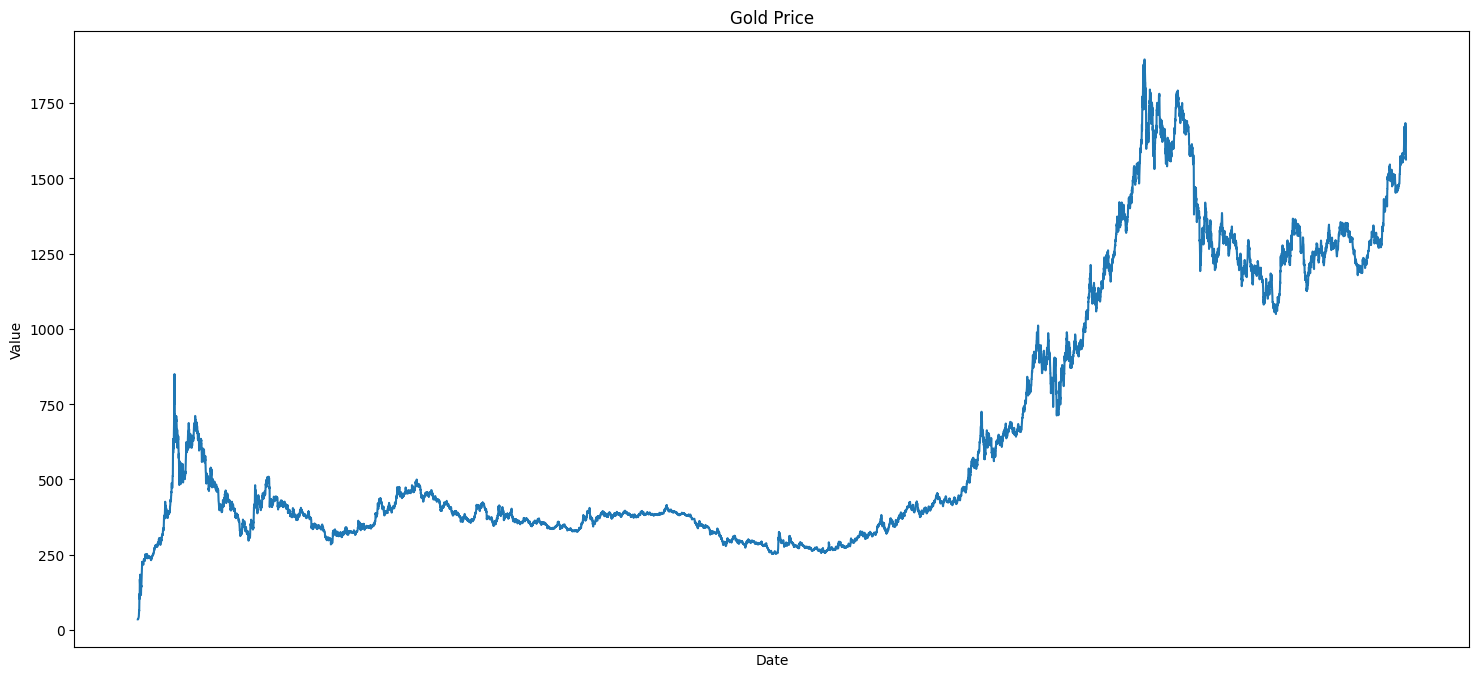

In [ ]:
plt.figure(figsize = (18,8))
sns.lineplot(data=df, x="Date", y="Value")
plt.title('Gold Price')
plt.xticks([]) 
plt.show()

In [ ]:
train_len = int(df.shape[0]*0.70)
train = df[0:train_len]
test =df[train_len:]

In [ ]:
train

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
7545,2007-10-11,749.00
7546,2007-10-12,749.50
7547,2007-10-15,758.85
7548,2007-10-16,756.75


In [ ]:
test

,Date,Value
7550,2007-10-18,764.15
7551,2007-10-19,763.00
7552,2007-10-22,751.25
7553,2007-10-23,758.25
7554,2007-10-24,757.50
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [ ]:
#Naive Method

y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Value'][train_len -1]

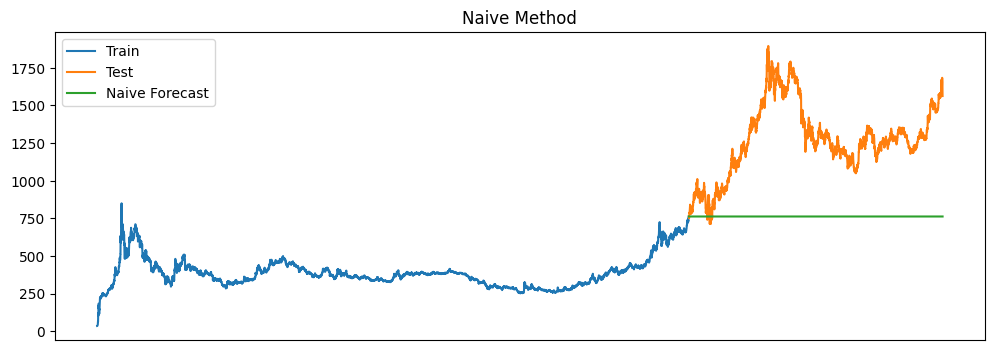

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(train['Value'], label='Train')
plt.plot(test['Value'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.xticks([]) 
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test['Value'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Value']-y_hat_naive['naive_forecast'])/test['Value'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,563.3,37.84


In [ ]:
#Simple Average 
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Value'].mean()

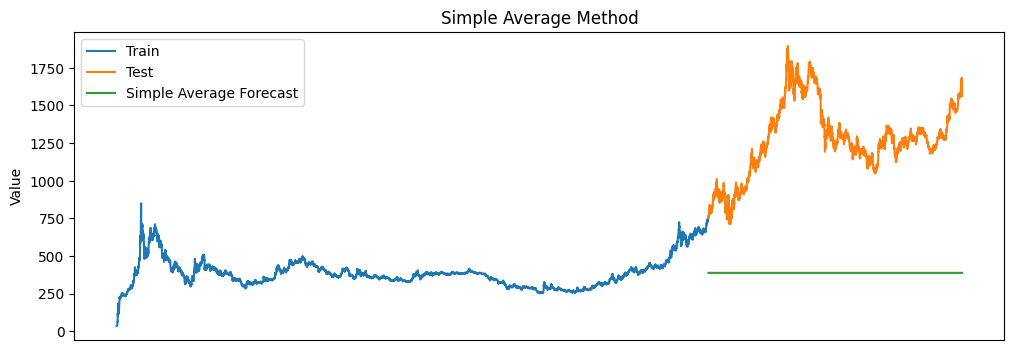

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(train.index, train['Value'], label='Train')
plt.plot(test.index, test['Value'], label='Test')
plt.plot(test.index, y_hat_avg['avg_forecast'], label='Simple Average Forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.ylabel('Value')
plt.xticks([]) 
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test['Value'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Value'], y_hat_avg['avg_forecast'])/test['Value'])*100,2)

results = pd.DataFrame({'Method':['Simple Average method'], 'MAPE' : [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Average method,916.37,100.0


In [ ]:
#Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# create a copy of the test data
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = train['Value'].mean()

# fit the SES model to the training data
model = SimpleExpSmoothing(train['Value'])
model_fit = model.fit()

# make predictions on the test data using the fitted model
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))

# print the forecasted values
print(y_hat_ses['ses_forecast'])

7550     762.241262
7551     762.241262
7552     762.241262
7553     762.241262
7554     762.241262
            ...    
10782    762.241262
10783    762.241262
10784    762.241262
10785    762.241262
10786    762.241262
Name: ses_forecast, Length: 3237, dtype: float64


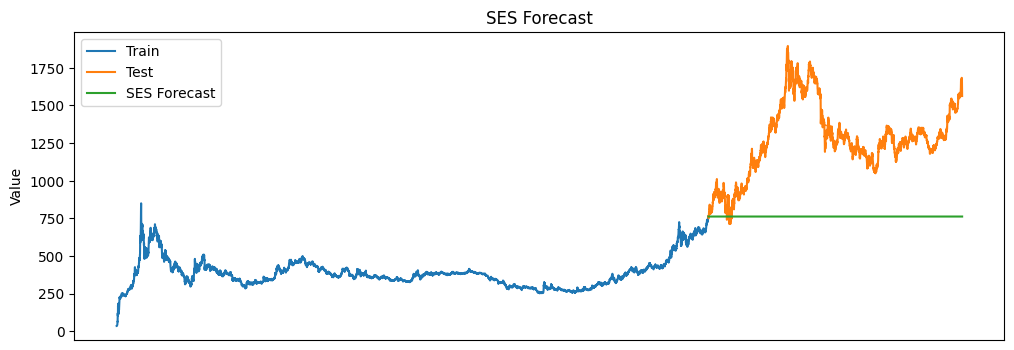

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(train.index, train['Value'], label='Train')
plt.plot(test.index, test['Value'], label='Test')
plt.plot(test.index, y_hat_ses['ses_forecast'], label='SES Forecast')
plt.legend(loc='best')
plt.title('SES Forecast')
plt.ylabel('Value')
plt.xticks([]) 
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

# create a copy of the test data
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = train['Value'].mean()

# fit the SES model to the training data
model = SimpleExpSmoothing(train['Value'])
model_fit = model.fit()

# make predictions on the test data using the fitted model
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))

# calculate the evaluation metrics
rmse = np.sqrt(mean_squared_error(test['Value'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Value'] - y_hat_ses['ses_forecast'])/test['Value'])*100, 2)

# create a results DataFrame
results = pd.DataFrame({'Method': ['SES'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]

# display the evaluation metrics
print(results)

  Method    RMSE   MAPE
0    SES  563.54  37.86


In [ ]:
#Finding optimal number of epochs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

# Load the data
df = pd.read_csv("gold_price_data.csv")

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train = df[0:train_size]
test = df[train_size:len(df)]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['Value'].values.reshape(-1, 1))

# Create sequences
lookback = 100

def create_sequences(data, lookback):
    X = []
    y = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

X_train, y_train = create_sequences(train_scaled, lookback)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=32))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Determine the optimal number of epochs
num_epochs = len(history.history['loss'])

print("Optimal number of epochs: ", num_epochs)

Epoch 1/100
214/214 [==============================] - 32s 123ms/step - loss: 8.7963e-04 - val_loss: 6.2839e-04
Epoch 2/100
214/214 [==============================] - 26s 122ms/step - loss: 5.7124e-05 - val_loss: 5.0721e-04
Epoch 3/100
214/214 [==============================] - 25s 118ms/step - loss: 5.2602e-05 - val_loss: 2.8610e-04
Epoch 4/100
214/214 [==============================] - 25s 115ms/step - loss: 4.3968e-05 - val_loss: 2.6895e-04
Epoch 5/100
214/214 [==============================] - 26s 119ms/step - loss: 3.8806e-05 - val_loss: 3.3174e-04
Epoch 6/100
214/214 [==============================] - 26s 120ms/step - loss: 3.6732e-05 - val_loss: 5.5384e-04
Epoch 7/100
214/214 [==============================] - 26s 121ms/step - loss: 3.4651e-05 - val_loss: 4.7416e-04
Optimal number of epochs:  7


Learning rate: 0.001000
Epoch 1/25
267/267 [==============================] - 31s 99ms/step - loss: 0.0015 - lr: 0.0010
Learning rate: 0.002800
Epoch 2/25
267/267 [==============================] - 31s 117ms/step - loss: 1.3023e-04 - lr: 0.0028
Learning rate: 0.004600
Epoch 3/25
267/267 [==============================] - 25s 94ms/step - loss: 1.1139e-04 - lr: 0.0046
Learning rate: 0.006400
Epoch 4/25
267/267 [==============================] - 26s 96ms/step - loss: 1.6571e-04 - lr: 0.0064
Learning rate: 0.008200
Epoch 5/25
267/267 [==============================] - 26s 99ms/step - loss: 7.6038e-05 - lr: 0.0082
Learning rate: 0.010000
Epoch 6/25
267/267 [==============================] - 25s 93ms/step - loss: 7.9619e-05 - lr: 0.0100
Learning rate: 0.000905
Epoch 7/25
267/267 [==============================] - 25s 94ms/step - loss: 3.5673e-05 - lr: 9.0484e-04
Learning rate: 0.000819
Epoch 8/25
267/267 [==============================] - 26s 96ms/step - loss: 3.1689e-05 - lr: 8.1873e-04
Lea

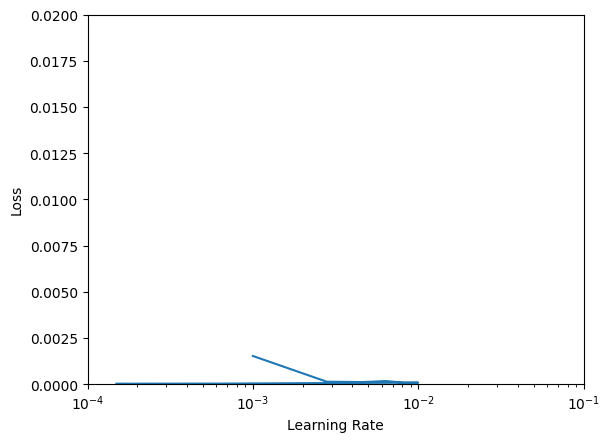

In [ ]:
#Finding optimal learning rate
import math
from keras.callbacks import LearningRateScheduler

# Define the learning rate schedule
def lr_schedule(epoch):
    """
    Learning rate schedule:
    - Starts at 0.001
    - Increases linearly from 0.001 to 0.01 over the first 5 epochs
    - Decreases exponentially from 0.01 to 0.0001 over the next 20 epochs
    """
    lr = 0.001
    if epoch > 5:
        lr = lr * math.exp(-0.1 * (epoch - 5))
    elif epoch > 0:
        lr = lr + (0.01 - 0.001) / 5 * epoch
    print(f"Learning rate: {lr:.6f}")
    return lr

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=32))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with learning rate schedule
lr_scheduler = LearningRateScheduler(lr_schedule)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, callbacks=[lr_scheduler])
lrs = [lr_schedule(epoch) for epoch in range(25)]
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 0.02])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()



In [ ]:
# Find the optimal learning rate value
lrs = [lr_schedule(epoch) for epoch in range(25)]
losses = history.history["loss"]
optimal_lr_index = np.argmin(losses)
optimal_lr = lrs[optimal_lr_index]
print(f"Optimal learning rate: {optimal_lr:.6f}")

Learning rate: 0.001000
Learning rate: 0.002800
Learning rate: 0.004600
Learning rate: 0.006400
Learning rate: 0.008200
Learning rate: 0.010000
Learning rate: 0.000905
Learning rate: 0.000819
Learning rate: 0.000741
Learning rate: 0.000670
Learning rate: 0.000607
Learning rate: 0.000549
Learning rate: 0.000497
Learning rate: 0.000449
Learning rate: 0.000407
Learning rate: 0.000368
Learning rate: 0.000333
Learning rate: 0.000301
Learning rate: 0.000273
Learning rate: 0.000247
Learning rate: 0.000223
Learning rate: 0.000202
Learning rate: 0.000183
Learning rate: 0.000165
Learning rate: 0.000150
Optimal learning rate: 0.000183


In [ ]:
#Finding optimal batch size 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv("gold_price_data.csv")

# Split the data into train, validation and test sets
train_size = int(len(df) * 0.6)
val_size = int(len(df) * 0.2)
test_size = len(df) - train_size - val_size
train, val, test = np.split(df.sample(frac=1), [train_size, train_size+val_size])

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['Value'].values.reshape(-1, 1))
val_scaled = scaler.transform(val['Value'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['Value'].values.reshape(-1, 1))

# Create sequences
lookback = 100

def create_sequences(data, lookback):
    X = []
    y = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

X_train, y_train = create_sequences(train_scaled, lookback)
X_val, y_val = create_sequences(val_scaled, lookback)

# Define the hyperparameters to tune
batch_sizes = [16, 32, 64, 128]

# Initialize variables to store the results
best_batch_size = None
best_test_loss = float('inf')

# Train the models with different batch sizes
for batch_size in batch_sizes:
    print("Training with batch size:", batch_size)
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=32))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size,
                        validation_data=(X_val, y_val), callbacks=[es])

    # Evaluate the model on the test set
    X_test, y_test = create_sequences(test_scaled, lookback)
    test_loss = model.evaluate(X_test, y_test)
    
    print("Test loss with batch size {}: {}".format(batch_size, test_loss))
    
    # Update the best batch size
    if test_loss < best_test_loss:
        best_batch_size = batch_size
        best_test_loss = test_loss

# Print the optimal batch size
print("Optimal batch size:", best_batch_size)



Training with batch size: 16
Epoch 1/100
399/399 [==============================] - 55s 125ms/step - loss: 0.0563 - val_loss: 0.0575
Epoch 2/100
399/399 [==============================] - 48s 120ms/step - loss: 0.0552 - val_loss: 0.0562
Epoch 3/100
399/399 [==============================] - 45s 113ms/step - loss: 0.0546 - val_loss: 0.0562
Epoch 4/100
399/399 [==============================] - 46s 116ms/step - loss: 0.0547 - val_loss: 0.0560
Epoch 5/100
399/399 [==============================] - 45s 113ms/step - loss: 0.0547 - val_loss: 0.0563
Epoch 6/100
399/399 [==============================] - 59s 149ms/step - loss: 0.0547 - val_loss: 0.0563
Epoch 7/100
399/399 [==============================] - 49s 123ms/step - loss: 0.0544 - val_loss: 0.0561
Epoch 8/100
399/399 [==============================] - 46s 116ms/step - loss: 0.0545 - val_loss: 0.0561
Epoch 9/100
399/399 [==============================] - 46s 115ms/step - loss: 0.0545 - val_loss: 0.0566
Epoch 10/100
399/399 [=============

In [ ]:
#Finding optimum activation function
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Load the data
df = pd.read_csv("gold_price_data.csv")

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train = df[0:train_size]
test = df[train_size:len(df)]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['Value'].values.reshape(-1, 1))

# Create sequences
lookback = 100

def create_sequences(data, lookback):
    X = []
    y = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

X_train, y_train = create_sequences(train_scaled, lookback)

# Define the LSTM model
def create_model(activation):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1), activation=activation))
    model.add(LSTM(units=32, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    return model

# Create a Keras regressor
model = KerasRegressor(build_fn=create_model)

# Define the grid search parameters
param_grid = {'activation': ['relu', 'tanh', 'sigmoid']}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the results
print("Best activation function: ", grid_result.best_params_['activation'])


<ipython-input-17-e6a1b181e9b1>:47: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model)


267/267 [==============================] - 38s 117ms/step - loss: 0.0014 - mse: 0.0014
Best activation function:  tanh


In [ ]:
#Finding optimal number of layers, more layers allows for more complex learning and can prevent overfitting
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

#Load the data
df = pd.read_csv("gold_price_data.csv")

#Split the data into train and test sets
train_size = int(len(df) * 0.8)
train = df[0:train_size]
test = df[train_size:len(df)]

#Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['Value'].values.reshape(-1, 1))

#Create sequences
lookback = 100

def create_sequences(data, lookback):
    X = []
    y = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

X_train, y_train = create_sequences(train_scaled, lookback)

#Define the LSTM model
def create_model(n_layers=1):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    for i in range(n_layers-1):
        model.add(LSTM(units=32, return_sequences=True))
    model.add(LSTM(units=32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

#Create the grid search object
param_grid = {'n_layers': [1, 2, 3]}
model = KerasRegressor(build_fn=create_model, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

#Print the results
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
results_df = pd.DataFrame(grid_result.cv_results_)
results_df.sort_values(by=['rank_test_score'], inplace=True)
for idx, row in results_df.iterrows():
    print("{:<3} {:.5f} (+/- {:.5f}) for {}".format(row['rank_test_score'], row['mean_test_score'], row['std_test_score'], row['params']))
    print("Optimal Score:", grid_result.best_score_)


<ipython-input-26-f7516777790c>:50: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best: -0.00010489889852275762 using {'n_layers': 1}
1   -0.00010 (+/- 0.00007) for {'n_layers': 1}
Optimal Score: -0.00010489889852275762
2   -0.00042 (+/- 0.00047) for {'n_layers': 2}
Optimal Score: -0.00010489889852275762
3   -0.00062 (+/- 0.00071) for {'n_layers': 3}
Optimal Score: -0.00010489889852275762


In [ ]:
#Find optimum Sequence Length 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Load the data
df = pd.read_csv("gold_price_data.csv")

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df['Value'].values.reshape(-1, 1))

# Define the sequence length range to test
sequence_lengths = [25,50,75,100]

# Define the model architecture
def create_model(sequence_length):
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(sequence_length, 1)))
    model.add(Dense(units=1))
    return model

# Train and evaluate the models for different sequence lengths
mse_list = []
for sequence_length in sequence_lengths:
    # Create sequences
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Split the data into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Create the model
    model = create_model(sequence_length)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Evaluate the model
    y_pred = scaler.inverse_transform(model.predict(X_test))
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)
    print("Sequence length:", sequence_length, "MSE:", mse)

# Find the best sequence length
best_sequence_length = sequence_lengths[np.argmin(mse_list)]
print("Best sequence length:", best_sequence_length)


Epoch 1/50
270/270 [==============================] - 11s 31ms/step - loss: 0.0018 - val_loss: 3.1757e-04
Epoch 2/50
270/270 [==============================] - 4s 16ms/step - loss: 8.7541e-05 - val_loss: 2.0391e-04
Epoch 3/50
270/270 [==============================] - 6s 21ms/step - loss: 8.0907e-05 - val_loss: 2.2944e-04
Epoch 4/50
270/270 [==============================] - 5s 17ms/step - loss: 7.4819e-05 - val_loss: 1.6114e-04
Epoch 5/50
270/270 [==============================] - 5s 18ms/step - loss: 7.2549e-05 - val_loss: 1.4861e-04
Epoch 6/50
270/270 [==============================] - 5s 19ms/step - loss: 6.1892e-05 - val_loss: 9.7148e-04
Epoch 7/50
270/270 [==============================] - 5s 17ms/step - loss: 6.7632e-05 - val_loss: 1.5407e-04
Epoch 8/50
270/270 [==============================] - 6s 21ms/step - loss: 5.3767e-05 - val_loss: 3.3414e-04
Epoch 9/50
270/270 [==============================] - 4s 16ms/step - loss: 5.4511e-05 - val_loss: 1.2925e-04
Epoch 10/50
270/270 [=

In [ ]:
#Best Values
#Number of epochs 7 
#Optimal learning rate: 0.000183
#Optimal batch size: 32
#Best activation function:  tanh
#1 layer
#Sequence Length : 50
#LSTM units : Build model using the above results and apply the keras tuner function in order to find lstm units 

Epoch 1/7
269/269 [==============================] - 16s 33ms/step - loss: 0.0025
Epoch 2/7
269/269 [==============================] - 9s 34ms/step - loss: 7.5823e-05
Epoch 3/7
269/269 [==============================] - 10s 37ms/step - loss: 7.4513e-05
Epoch 4/7
269/269 [==============================] - 8s 31ms/step - loss: 6.8355e-05
Epoch 5/7
269/269 [==============================] - 9s 35ms/step - loss: 6.5139e-05
Epoch 6/7
269/269 [==============================] - 8s 29ms/step - loss: 7.1076e-05
Epoch 7/7
68/68 [==============================] - 2s 13ms/step
MSE: 642.33163925212
RMSE: 25.34426245232084


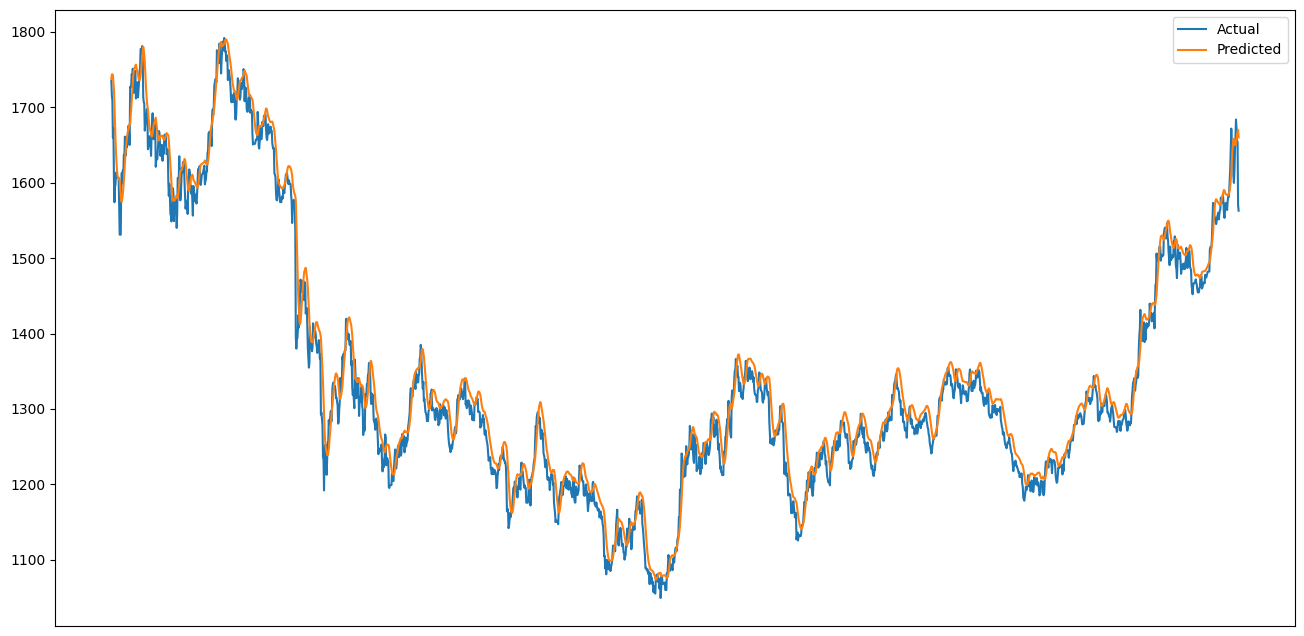

In [6]:
#Optimal LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

# Load the data
df = pd.read_csv("gold_price_data.csv")

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train = df[0:train_size]
test = df[train_size:len(df)]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['Value'].values.reshape(-1, 1))

# Create sequences
lookback = 50

def create_sequences(data, lookback):
    X = []
    y = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

X_train, y_train = create_sequences(train_scaled, lookback)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), activation='tanh'))
model.add(Dense(1))

learning_rate = 0.000183
batch_size = 32

optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=7, batch_size=batch_size)

# Prepare the test data
inputs = df['Value'].values[len(df) - len(test) - lookback:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test, y_test = create_sequences(inputs, lookback)

# Get predictions
predictions = model.predict(X_test)

# Inverse scaling
predictions = scaler.inverse_transform(predictions)

# Print MSE and RMSE
mse = mean_squared_error(test['Value'].values, predictions)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

# Plot the predictions
plt.figure(figsize=(16,8))
plt.plot(test['Value'].values)
plt.plot(predictions)
plt.legend(['Actual', 'Predicted'])
plt.xticks([]) 
plt.show()


In [7]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['Value'].values, predictions)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

MSE: 642.33163925212
RMSE: 25.34426245232084


68/68 [==============================] - 1s 11ms/step
MSE: 492.54426538286634
RMSE: 22.19333831091813


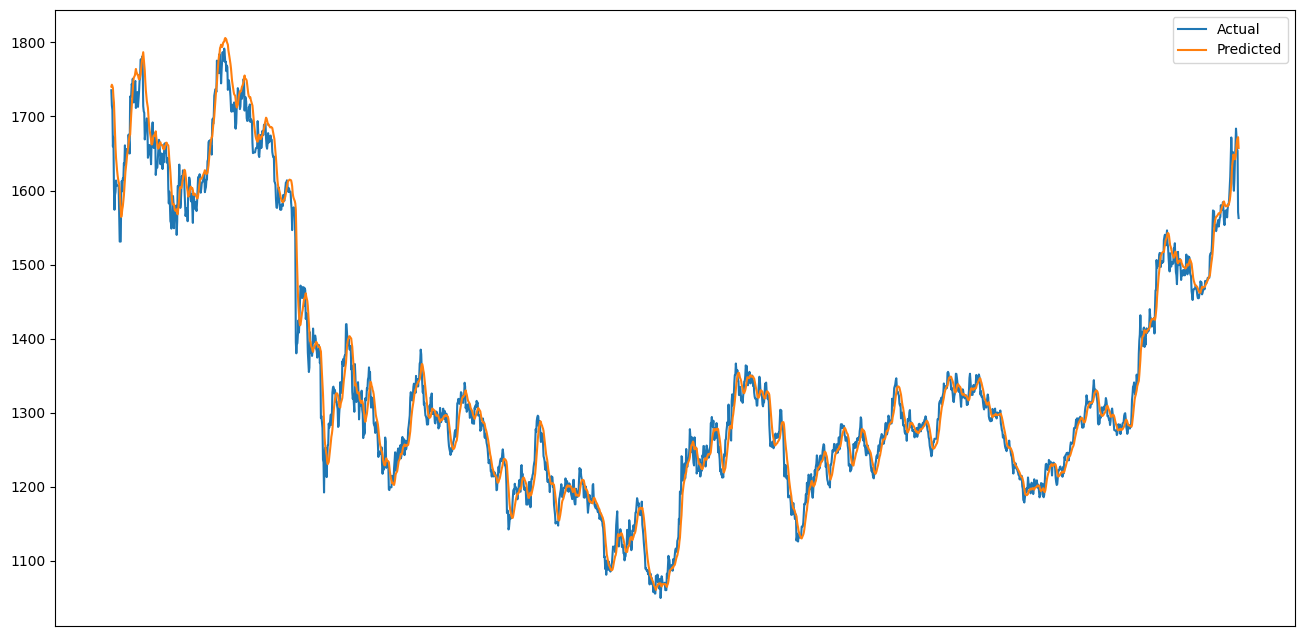

In [4]:
#Optimal LSTM with keras tuning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

# Load the data
df = pd.read_csv("gold_price_data.csv")

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train = df[0:train_size]
test = df[train_size:len(df)]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['Value'].values.reshape(-1, 1))

# Create sequences
lookback = 50

def create_sequences(data, lookback):
    X = []
    y = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

X_train, y_train = create_sequences(train_scaled, lookback)

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   input_shape=(X_train.shape[1], 1),
                   activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=hp.Float('learning_rate', min_value=1e-6, max_value=1e-3, sampling='LOG')),
                  loss=MeanSquaredError())
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='gold_price_prediction'
)

tuner.search(X_train, y_train,
             epochs=7,
             batch_size=32,
             validation_split=0.2)

best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model to a file
best_model.save('bmodel')

# Prepare the test data
inputs = df['Value'].values[len(df) - len(test) - lookback:]
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test, y_test = create_sequences(inputs, lookback)

# Get predictions
predictions = best_model.predict(X_test)

# Inverse scaling
predictions = scaler.inverse_transform(predictions)

# Print MSE and RMSE
mse = mean_squared_error(test['Value'].values, predictions)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
# Plot the predictions
plt.figure(figsize=(16,8))
plt.plot(test['Value'].values)
plt.plot(predictions)
plt.legend(['Actual', 'Predicted'])
plt.xticks([]) 
plt.show()


In [5]:
tuner.results_summary()

Results summary
Results in my_dir/gold_price_prediction
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
units: 64
activation: relu
learning_rate: 5.561453206329315e-06
Score: 0.00022383097287577888

Trial 4 summary
Hyperparameters:
units: 224
activation: sigmoid
learning_rate: 1.1028568901588678e-05
Score: 0.003436295441739882

Trial 1 summary
Hyperparameters:
units: 32
activation: relu
learning_rate: 3.997743842873214e-05
Score: 0.006096830902000268

Trial 0 summary
Hyperparameters:
units: 64
activation: sigmoid
learning_rate: 8.030512585141102e-06
Score: 0.01041360572950604

Trial 3 summary
Hyperparameters:
units: 480
activation: sigmoid
learning_rate: 1.1068284175502953e-06
Score: 0.026947747295101483


In [6]:
# Reshape y_test to match predictions shape
y_test = y_test.reshape(-1, 1)

# Inverse scaling for y_test
y_test = scaler.inverse_transform(y_test)
# Create a pandas DataFrame with the actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test.reshape(-1),
    'Predicted': predictions.reshape(-1)
})
# Print the first 10 rows of the results DataFrame
print(results_df.head(10))
# Print the last 10 rows of the results DataFrame
print(results_df.tail(10))


   Actual    Predicted
0  1735.5  1740.431763
1  1715.0  1742.918213
2  1709.0  1741.185913
3  1659.5  1738.554810
4  1672.5  1726.779297
5  1603.0  1718.789551
6  1574.0  1698.437256
7  1594.0  1675.046509
8  1598.0  1658.159790
9  1613.5  1644.176880
       Actual    Predicted
2148  1599.65  1646.946899
2149  1615.50  1643.108643
2150  1641.85  1642.090576
2151  1659.60  1645.614258
2152  1683.65  1651.749023
2153  1672.50  1661.537476
2154  1655.70  1668.010498
2155  1653.75  1670.486328
2156  1570.70  1672.061035
2157  1562.80  1657.499023


In [7]:
# Calculate area under the curve for actual and predicted values
area_actual = np.trapz(test['Value'].values)
area_predicted = np.trapz(predictions.flatten())

# Print the areas
print("Area under the curve for actual values:", area_actual)
print("Area under the curve for predicted values:", area_predicted)
# Calculate the difference between the areas
area_diff = abs(area_actual - area_predicted)

# Print the difference between the areas
print("Difference between actual and predicted area under the curve:", area_diff)


Area under the curve for actual values: 2894999.05
Area under the curve for predicted values: 2901045.5
Difference between actual and predicted area under the curve: 6046.450000000186


336/336 [==============================] - 4s 12ms/step


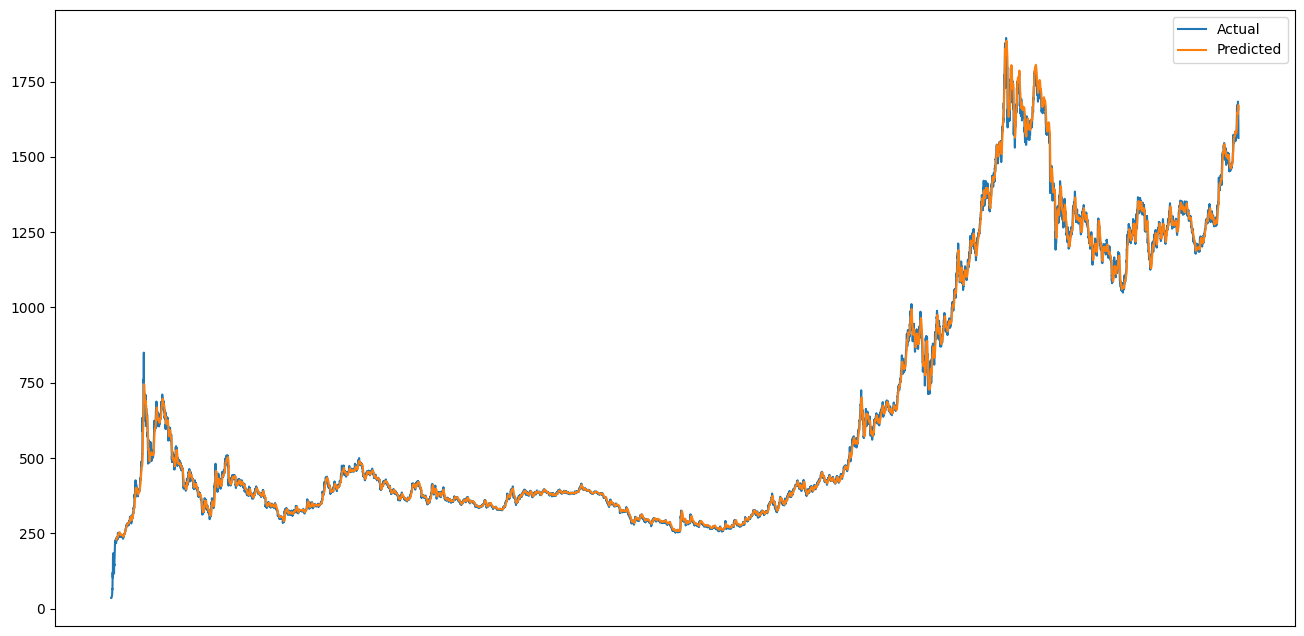

          Date   Value  Predictions
0   1970-01-01   35.20          NaN
1   1970-04-01   35.10          NaN
2   1970-07-01   35.40          NaN
3   1970-10-01   36.20          NaN
4   1971-01-01   37.40          NaN
..         ...     ...          ...
95  1979-03-22  242.85   244.115051
96  1979-03-23  242.50   244.354309
97  1979-03-26  245.25   244.537567
98  1979-03-27  244.35   245.157654
99  1979-03-28  244.40   245.589645

[100 rows x 3 columns]
             Date    Value  Predictions
10687  2019-10-28  1492.40  1500.181519
10688  2019-10-29  1486.75  1499.958130
10689  2019-10-30  1492.10  1498.811279
10690  2019-10-31  1510.95  1498.735962
10691  2019-11-01  1508.80  1502.066162
...           ...      ...          ...
10782  2020-03-09  1672.50  1661.537476
10783  2020-03-10  1655.70  1668.010498
10784  2020-03-11  1653.75  1670.486328
10785  2020-03-12  1570.70  1672.061035
10786  2020-03-13  1562.80  1657.499023

[100 rows x 3 columns]


In [8]:
#Loading extracted model onto main dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('bmodel')

# Load the data
df = pd.read_csv('gold_price_data.csv')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Value'].values.reshape(-1, 1))

# Create sequences
lookback = 50

def create_sequences(data, lookback):
    X = []
    y = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

X, y = create_sequences(scaled_data, lookback)

# Get predictions
predictions = model.predict(X)

# Inverse scaling
predictions = scaler.inverse_transform(predictions)

# Add the predicted values to the original dataframe
df['Predictions'] = np.nan
df.iloc[lookback:len(df), -1] = predictions.reshape(-1)

# Plot the results
plt.figure(figsize=(16,8))
plt.plot(df['Value'].values)
plt.plot(df['Predictions'].values)
plt.legend(['Actual', 'Predicted'])
plt.xticks([]) 
plt.show()
# Print the first 10 rows of the dataframe
print(df.head(100))
# Print the last 10 rows of the dataframe
print(df.tail(100))
